<a href="https://colab.research.google.com/github/lmassaron/fine-tuning-workshop/blob/main/03_fine_tuning_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check the GPU information
!nvidia-smi

Thu Sep 25 13:45:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
| 30%   39C    P5             31W /  350W |     482MiB /  24576MiB |     41%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Install necessary libraries for model training and evaluation
%%capture
!pip install -U transformers trl peft accelerate bitsandbytes
!pip install tenacity

In [ ]:
# Import and print the versions of the installed libraries
import torch
import trl
import peft
import bitsandbytes

print(f"Using PyTorch version: {torch.__version__}")
print(f"Using TRL version: {trl.__version__}")
print(f"Using peft version: {peft.__version__}")
print(f"Using bitsandbytes version: {bitsandbytes.__version__}")

Using PyTorch version: 2.8.0+cu128
Using TRL version: 0.22.2
Using peft version: 0.17.1
Using bitsandbytes version: 0.47.0


In [ ]:
# Import various libraries needed for data handling, model loading, and training
import os
import gc
import warnings
import torch
import numpy as np
import pandas as pd
import torch
import subprocess
import sys
import random
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from huggingface_hub import login
from peft import LoraConfig
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import set_seed
from trl import SFTConfig, SFTTrainer

INFO 09-25 13:46:01 [__init__.py:216] Automatically detected platform cuda.


In [ ]:
DEMO = False

In [ ]:
# Define configuration parameters for the model and data
class Config:
    """Configuration parameters"""

    SIZE = "3-1b"
    MODEL_NAME = f"google/gemma-{SIZE}-it"
    OUTPUT_MODEL = f"gemma-{SIZE}-sherlock-expert"

    max_seq_length = 2048
    seed = 0

In [ ]:
# Initialization script to set up the environment and Hugging Face login
def init():
    """Initialization script"""
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # It is recommended to set the HF_TOKEN as an environment variable
    token = os.environ.get("HF_TOKEN")
    if token:
        login(token=token)
    else:
      try:
        from google.colab import userdata
        # Retrieve your Hugging Face token from Colab's secrets manager
        # The name 'HF_TOKEN' should match the name you used in the secrets tab
        hf_token = userdata.get('HF_TOKEN')

        # Check if the token was successfully retrieved
        if hf_token:
            # Log in to Hugging Face using the retrieved token
            # The `add_to_git_credential=True` argument is optional and useful if you plan to push models to the Hub
            login(token=hf_token, add_to_git_credential=True)
            print("Hugging Face login successful using Google Colab secrets!")
        else:
            print("Error: HF_TOKEN not found in Google Colab secrets or is empty.")
            print("Please ensure you have created a secret named 'HF_TOKEN' in the 'Secrets' tab (🔑) on the left sidebar.")
      except:
        print("HF_TOKEN not set. You might need to log in manually.")

    torch.cuda.empty_cache()
    gc.collect()
    warnings.filterwarnings("ignore")

def is_bfloat16_supported():
    """Checks if the current device supports bfloat16."""
    return torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8


def info_device():
    """Get device for PyTorch"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

def cleanup(objects=None):
    """Cleans the memory"""
    if objects is not None:
        for obj in objects:
            del obj
    torch.cuda.empty_cache()
    gc.collect()

def set_deterministic(seed):
  """Sets all seeds and CUDA settings for deterministic results."""
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU. [2, 3]
  set_seed(seed)

`install_flash_attn_conditionally` is a **smart installer** for the `flash-attn` library. Its main purpose is to **check your GPU's hardware and automatically install the correct, compatible version of the library**, or safely skip the installation if your GPU is not supported.

It works in three main steps:

1.  **Check for a GPU:** It first verifies that you have a CUDA-enabled NVIDIA GPU. If not, it does nothing.
2.  **Identify the GPU Architecture:** It then checks the GPU's "Compute Capability," which is like a version number that identifies its architecture (e.g., Turing, Ampere, Hopper).
3.  **Install the Correct Version:**
    *   For **modern GPUs** (Ampere or newer, capability >= 8.0), it installs the latest and fastest version of `flash-attn`.
    *   For **older Turing GPUs** (capability == 7.5), it installs a specific, older version of `flash-attn` that is compatible with that hardware.
    *   If the GPU is **not supported**, it prints a message and safely skips the installation to prevent errors.

This is necessary because `flash-attn` is a low-level library that relies on specific hardware features, so you need the right version for your specific GPU.


**FlashAttention is a highly optimized algorithm that completely re-imagines how the "attention" mechanism works inside a Transformer model.**

The standard attention mechanism is the biggest bottleneck in LLMs—it's slow and uses a massive amount of GPU memory because it has to constantly read and write a huge intermediate matrix to the GPU's main memory.

FlashAttention's key innovation is that it's "IO-aware." It cleverly reorganizes the math and uses the GPU's super-fast on-chip memory (SRAM) to perform the calculations in small chunks, **avoiding those slow, memory-intensive read/write operations.** The result is the same, but the process is dramatically faster and more memory-efficient.

The speed and memory savings from FlashAttention provide two game-changing benefits during the fine-tuning process:

1.  **Faster Training:** Because each training step is faster, your entire fine-tuning job can be completed **2-4 times faster**. This saves a huge amount of time and money on GPU compute costs.

2.  **Enables Longer Context:** This is its most powerful advantage. The memory usage of standard attention grows quadratically with the length of the text, making it nearly impossible to fine-tune on long documents. **FlashAttention's memory usage is linear**, meaning you can fine-tune your model on much longer context windows (e.g., 8k, 16k, or more) without running out of memory. This is crucial for building models that can understand long documents, summarize books, or handle extended conversations.

In [ ]:
def install_flash_attn_conditionally():
    """
    Checks the GPU's compute capability and installs the appropriate version of flash-attn.
    """
    if not torch.cuda.is_available():
        print("No CUDA-enabled GPU found. Skipping flash-attn installation.")
        return

    try:
        # Get the compute capability of the first available GPU
        major, minor = torch.cuda.get_device_capability(0)
        compute_capability = float(f"{major}.{minor}")
        gpu_name = torch.cuda.get_device_name(0)
        print(f"Found GPU: {gpu_name} with Compute Capability: {compute_capability}")

        # Check for Ampere, Ada, Hopper, or newer architectures (for FlashAttention 2)
        if compute_capability >= 8.0:
            # Ampere, Ada, and Hopper architectures support bfloat16 and are ideal for FlashAttention 2
            is_bf16_supported = torch.cuda.is_bf16_supported()
            if is_bf16_supported:
                print("GPU supports BF16 and is compatible with FlashAttention 2.")
                print("Proceeding with installation of the latest 'flash-attn'...")
                # Install the latest version of flash-attn
                install_package("flash-attn", "-q", "--no-build-isolation") # Pass arguments correctly
                return True
            else:
                 print("GPU architecture is compatible, but BF16 is not supported. Skipping installation.")
                 return False
        # Check for Turing architecture (for original FlashAttention)
        elif compute_capability == 7.5:
            print("Turing architecture GPU detected. Compatible with original FlashAttention (v1.x).")
            print("Proceeding with installation of 'flash-attn==1.0.9'...")
            # Install a specific version of flash-attn compatible with Turing
            install_package("flash-attn==1.0.9", "-q", "--no-build-isolation") # Pass arguments correctly
            return True

        else:
            print(f"GPU with compute capability {compute_capability} is not supported by flash-attn. Skipping installation.")
            return False
    except Exception as e:
        print(f"An error occurred during GPU check or installation: {e}")
        return False

def install_package(package_name, *pip_args):
    """
    A helper function to install a pip package using subprocess.
    """
    try:
        command = [sys.executable, "-m", "pip", "install", package_name]
        command.extend(pip_args) # Extend with individual arguments
        subprocess.check_call(command)
        print(f"Successfully installed {package_name}.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package_name}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [ ]:
# Initialize the environment, get parameters, device, and data type
init()
params = Config()
device = info_device()
dtype = torch.bfloat16 if is_bfloat16_supported() else torch.float16
print(f"Using dtype: {dtype}")
is_flash_attn_available = install_flash_attn_conditionally()
set_deterministic(params.seed)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Using device: cuda
Using dtype: torch.bfloat16
Found GPU: NVIDIA GeForce RTX 3090 with Compute Capability: 8.6
GPU supports BF16 and is compatible with FlashAttention 2.
Proceeding with installation of the latest 'flash-attn'...


In [ ]:
from tenacity import retry, stop_after_attempt, wait_fixed

# Function to load dataset from Hugging Face Hub with retries
@retry(stop=stop_after_attempt(5), wait=wait_fixed(10)) # Retry up to 5 times with 10 seconds delay
def get_data(repo_id, mapping_func=None, split="train"):
    """Upload HF dataset with retries"""
    print(f"Attempting to load dataset {repo_id}, split {split}...")
    data = load_dataset(repo_id, cache_dir="/tmp")[split]
    if mapping_func:
      data = data.map(mapping_func)
    print("Dataset loaded successfully!")
    return data

In [ ]:
# Load the Sherlock QA dataset
data = get_data(repo_id="lmassaron/Sherlock_QA")

Attempting to load dataset lmassaron/Sherlock_QA, split train...
Dataset loaded successfully!


In [ ]:
data

Dataset({
    features: ['messages'],
    num_rows: 50994
})

In [ ]:
# Deterministically sample k rows by setting a random_state
if DEMO:
    k = 1_000
else:
    k = len(data)
eval_proportion = 0.1
eval_size = int(k * eval_proportion)
train_size = k - eval_size

# Shuffle the dataset with a fixed seed for reproducibility
shuffled_data = data.shuffle(seed=params.seed)

# Select the first k elements to create your sample
sampled_data = shuffled_data.select(range(k))

# Split the sampled data into training and test sets
train_data = sampled_data.select(range(train_size))
eval_data = sampled_data.select(range(train_size, k))

In [ ]:
print(f"train examples: {len(train_data)}")
print(f"eval examples: {len(eval_data)}")

train examples: 45895
eval examples: 5099


This code block performs a **two-step cleaning process** on your training and evaluation datasets to improve their quality before fine-tuning.

1.  **Remove the System Prompt (`.map()`):**
    The first step, using `remove_system_prompt`, goes through every single conversation and **deletes the initial system prompt** (e.g., "You are a helpful assistant."). This is often done to force the model to learn the desired behavior purely from the user-assistant examples, rather than relying on a repetitive instruction.

2.  **Filter Out Useless Examples (`.filter()`):**
    The second step, using `is_example_useful`, inspects every conversation to see if it contains generic, unhelpful answers like "not specified" or "not mentioned". If it finds any of these phrases, it **removes the entire conversation** from the dataset. This ensures the model is only trained on high-quality examples where a meaningful answer was provided.

In [ ]:
def remove_system_prompt(example):
    if example['messages'][0]['role'] == 'system':
        # Return all messages except the first one
        return {"messages": example['messages'][1:]}
    return example

def is_example_useful(example):
    """
    Checks if an example is useful. An example is considered not useful if any
    of its messages contain one of the unwanted phrases.
    """
    unwanted_phrases = [
        "not specified",
        "not mentioned",
        "unknown",
        "no information provided",
    ]

    # Iterate through each message in the conversation
    for message in example["messages"]:
        # Ensure content is a string before checking
        content = message.get("content") or ""

        # Check if any unwanted phrase is in the message content
        if any(phrase in content.lower() for phrase in unwanted_phrases):
            return False  # Found an unwanted phrase, mark example for removal

    return True  # No unwanted phrases found, keep the example

train_data = train_data.map(remove_system_prompt)
eval_data = eval_data.map(remove_system_prompt)

train_data = train_data.filter(is_example_useful)
eval_data = eval_data.filter(is_example_useful)

In [ ]:
print(f"train examples: {len(train_data)}")
print(f"eval examples: {len(eval_data)}")

train examples: 43543
eval examples: 4819


In [ ]:
attn_implementation = "flash_attention_2" if is_flash_attn_available else "eager"

model = AutoModelForCausalLM.from_pretrained(
    params.MODEL_NAME,
    torch_dtype=dtype,
    device_map=device,
    attn_implementation=attn_implementation
)

tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME, max_seq_length=params.max_seq_length)

# Explicitly enable use_cache for faster inference
model.config.use_cache = True

In [ ]:
print(f"Model: {model.name_or_path}")
print(f"Device: {model.device}")
print(f"DType: {model.dtype}")
print(f"Attention Implementation: {attn_implementation}")

Model: google/gemma-3-1b-it
Device: cuda:0
DType: torch.bfloat16
Attention Implementation: flash_attention_2


### 1. `peft_config = LoraConfig(...)` - The LoRA Configuration

This block sets up the rules for **LoRA (Low-Rank Adaptation)**, which is a highly efficient fine-tuning technique. Instead of training the entire multi-billion parameter model, LoRA freezes the original model and only trains a tiny set of new, small matrices that are "injected" into the model's architecture.

**Key Parameters:**

*   **`r=32` (Rank):** This is the most important parameter. It controls the "capacity" or complexity of the small matrices you're training. A higher `r` means more trainable parameters, which can lead to better performance but also uses more memory. `32` is a solid, common choice.
*   **`lora_alpha=32`:** A scaling factor that controls the "strength" of the LoRA adaptations. A common and effective practice is to set `lora_alpha` equal to `r`.
*   **`lora_dropout=0`:** A regularization technique to prevent overfitting. `0` means it's turned off, which is common for LoRA since you are already training very few parameters.
*   **`bias="none"`:** Specifies that you will only train the main weight matrices and not the small bias parameters, which is a standard practice for LoRA efficiency.
*   **`task_type="CAUSAL_LM"`:** This is crucial. It tells the library that you are fine-tuning a model for next-token prediction (a generative, auto-regressive model like GPT or Llama).
*   **`target_modules=[...]`:** This is a list of **which layers inside the model you want to adapt**. The layers listed (`q_proj`, `k_proj`, `v_proj`, etc.) are the most critical components of the Transformer's attention mechanism. By targeting these, you get the most impact from your fine-tuning.

---

### 2. `training_arguments = SFTConfig(...)` - The Training Rulebook

This block defines the complete set of rules and hyperparameters for the entire supervised fine-tuning process. It's the "master plan" for the trainer.

**Key Parameters (Grouped by Function):**

*   **Core Training Loop:**
    *   `output_dir="logs"`: Where to save model checkpoints and training logs.
    *   `num_train_epochs=1`: The number of times to go through the entire training dataset. `1` is often sufficient for fine-tuning.
    *   `seed=params.seed`: Sets a random seed to ensure your results are reproducible.

*   **Memory and Batching:**
    *   `per_device_train_batch_size=1`: The number of examples to process in a single step. `1` is very small, used to conserve memory.
    *   `gradient_accumulation_steps=8`: This is a trick to simulate a larger batch size. The trainer will process 8 small batches of size 1 and *accumulate* their gradients before making a single update to the model. This achieves the stability of a larger batch size (`1 * 8 = 8`) without the high memory cost.

*   **Optimizer and Learning Rate:**
    *   `optim="adamw_torch_fused"`: Specifies the optimization algorithm. `"adamw_torch_fused"` is a highly efficient and fast version of the standard AdamW optimizer.
    *   `learning_rate=2e-4`: The step size the optimizer takes. This is one of the most important hyperparameters.
    *   `lr_scheduler_type="cosine"`: A popular strategy where the learning rate starts high and then gradually decreases in a cosine curve, which helps the model settle into a good minimum.
    *   `warmup_ratio=0.1`: For the first 10% of training, the learning rate will gradually ramp *up* before starting its decay. This helps stabilize the model at the beginning.

*   **Hardware and Precision:**
    *   `fp16` and `bf16`: These control the numerical precision. The code cleverly checks if your GPU supports `bf16` (the better option) and uses it, otherwise falling back to `fp16`. Using 16-bit precision dramatically reduces memory usage and speeds up training.

*   **Logging and Evaluation:**
    *   `logging_steps` and `eval_steps`: How often (in steps) to log training metrics and run an evaluation on the `eval_data`.
    *   `eval_strategy='steps'`: Specifies that evaluation should happen at regular step intervals.
    *   `report_to="tensorboard"`: Sends the logs to TensorBoard for visualization.

*   **Dataset Handling:**
    *   `dataset_text_field="messages"`: Critically tells the trainer which column in your dataset contains the conversational data.
    *   `max_length`: Sets the maximum sequence length for the model, truncating longer examples.

---

### 3. `trainer = SFTTrainer(...)` - The Trainer Initialization

This is the final step where you bring everything together. You create the `SFTTrainer` object, which is the engine that will actually execute the training process based on all the configurations you've just defined.

**It takes in:**
*   `model=model`: The actual language model you want to fine-tune.
*   `train_dataset=train_data`: Your training data.
*   `eval_dataset=eval_data`: Your evaluation data for checking performance during training.
*   `peft_config=peft_config`: The LoRA rules, which tells the trainer to use this efficient fine-tuning method.
*   `processing_class=tokenizer`: The tokenizer needed to process the text data.
*   `args=training_arguments`: The complete rulebook for the training process.

In [ ]:
# LoRA configuration
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    lora_dropout=0,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

# SFT (Supervised Fine-tuning) configuration
training_arguments = SFTConfig(
    output_dir="logs",
    seed=params.seed,
    num_train_epochs=1,
    gradient_checkpointing=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",
    save_steps=0,
    logging_steps=25 if DEMO else 500,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=not(is_bfloat16_supported()),
    bf16=is_bfloat16_supported(),
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.1,
    group_by_length=False,
    eval_strategy='steps',
    eval_steps = 25 if DEMO else 500,
    eval_accumulation_steps=1,
    lr_scheduler_type="cosine",
    dataset_text_field="messages",
    packing=False,
    max_length=params.max_seq_length,
    report_to="tensorboard",
)

# Initialize the trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,
)

In [ ]:
# Train model
trainer.train()

# Save the fine-tuned LoRA adapter
trainer.model.save_pretrained("trained-model")

It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `flash_attention_2`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
500,2.856700,1.945061,1.973937,118400.000000,0.651981
1000,1.820200,1.808372,1.809304,237475.000000,0.669743
1500,1.703400,1.729094,1.757508,355715.000000,0.679833
2000,1.621900,1.677252,1.704830,473546.000000,0.684471
2500,1.620200,1.637118,1.595342,591615.000000,0.690248
3000,1.571900,1.599872,1.554696,710596.000000,0.694682
3500,1.530300,1.569115,1.556101,829078.000000,0.699163
4000,1.520300,1.537899,1.497680,947322.000000,0.703198
4500,1.484100,1.520827,1.499347,1065610.000000,0.705701
5000,1.484600,1.510438,1.500540,1184060.000000,0.706918


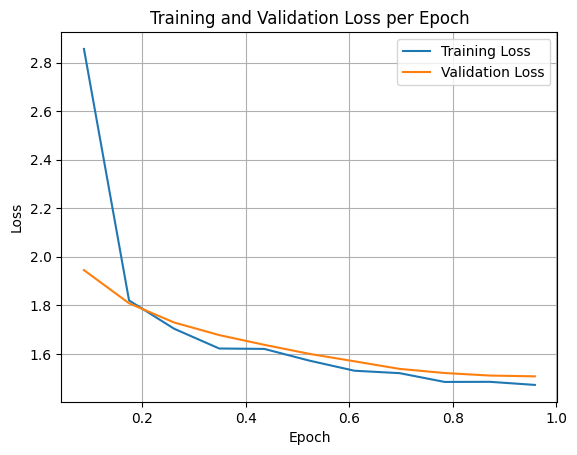

In [ ]:
# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
if not DEMO:
  lora_output_dir = f"{params.OUTPUT_MODEL}-lora"
  trainer.model.save_pretrained(lora_output_dir)
  print(f"LoRA adapters saved to {lora_output_dir}")
  # Also save the tokenizer with the LoRA adapters for convenience
  tokenizer.save_pretrained(lora_output_dir)

  # Define the name for your repository on the Hub
  repo_name = "lmassaron/" + lora_output_dir

  # Push the model to the Hub
  model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

LoRA adapters saved to gemma-3-1b-sherlock-expert-lora


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/gemma-3-1b-sherlock-expert-lora


In [ ]:
if not DEMO:
  print("\nMerging the final model")
  merged_model = trainer.model.merge_and_unload()

  # Save model and tokenizer
  output_path = f"{params.OUTPUT_MODEL}"
  print(f"Saving the final model to {output_path}")
  merged_model.save_pretrained(output_path)
  tokenizer.save_pretrained(output_path)

  # Define the name for your repository on the Hub
  repo_name = "lmassaron/" + output_path

  # Push the model to the Hub
  model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")


Merging the final model
Saving the final model to gemma-3-1b-sherlock-expert


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/gemma-3-1b-sherlock-expert
